In [ ]:
""" INSTALL LIBRARIES """

# upgrade pip
!pip -q install --upgrade pip

# core data libs
!pip -q install pandas pyarrow matplotlib seaborn scikit-learn

# pytorch
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# PyTorch Geometric
!pip -q install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
!pip -q install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
!pip -q install torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
!pip -q install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
!pip -q install torch-geometric



In [ ]:
from google.colab import drive

In [ ]:
""" DATA LOADING AND PREPROCESSING """
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import os
from google.colab import drive  # <-- ADD THIS LINE

# load full dataset
drive.mount('/content/drive', force_remount=True)
path = "/content/drive/MyDrive/df_before.parquet"
assert os.path.exists(path), f"File not found: {path}"

# load all columns needed for the model
all_cols = [
    'Timestamp', 'Indoor_CO2_PPM', 'Indoor_Temperature_C', 'Indoor_RH_Percent',
    'Illumination_LUX', 'Window_1_1', 'Window_2_1', 'Window_2_2',
    'Door_1_1', 'Outdoor_Temp_C', 'Outdoor_RH_Percent', 'Wind_Speed_MPH',
    'Solar_Radiation_DNI_W_m2', 'Temp_Diff', 'hour', 'dayofweek', 'month', 'is_weekend',
    'HVAC_Energy_usage_KWh'
]
df = pd.read_parquet(path, columns=all_cols)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)
print(f"Full dataset loaded. Shape: {df.shape}")

# define features and target
sensor_cols = [
    'Indoor_CO2_PPM', 'Indoor_Temperature_C', 'Indoor_RH_Percent',
    'Illumination_LUX', 'Window_1_1', 'Window_2_1', 'Window_2_2',
    'Door_1_1', 'Outdoor_Temp_C', 'Outdoor_RH_Percent', 'Wind_Speed_MPH',
    'Solar_Radiation_DNI_W_m2', 'Temp_Diff', 'hour', 'dayofweek', 'month', 'is_weekend'
]
target_col = 'HVAC_Energy_usage_KWh'

# impute dropna() flaws
cols_to_impute = sensor_cols + [target_col]
df[cols_to_impute] = df[cols_to_impute].fillna(method='ffill').fillna(method='bfill')

# fill NaNs with 0
nans_left = df.isna().sum().sum()
if nans_left > 0:
    df = df.fillna(0)

# Clamp target variable to prevent log(negative) errors
df[target_col] = df[target_col].clip(lower=0.0)

# scale data
scaler = StandardScaler()
X_all = scaler.fit_transform(df[sensor_cols].values)  # [T, N_nodes]
y_all = df[target_col].values   # [T]

# Create the two targets
active_threshold = 1e-6
y_bin_all = (y_all > active_threshold).astype(np.float32)
y_reg_all = np.log1p(y_all * 1e6)  # log1p scaled regression target

# memory-safe dataset
class MemorySafeHVACDataset(Dataset):
    def __init__(self, X_data, y_bin_data, y_reg_data, seq_len, horizon):
        self.X_data = X_data        # The FULL [T, N_nodes] array
        self.y_bin_data = y_bin_data  # The FULL [T] array
        self.y_reg_data = y_reg_data  # The FULL [T] array
        self.seq_len = seq_len
        self.horizon = horizon
        # Total length is T, but we can't index the last seq_len + horizon steps
        self.n_samples = len(X_data) - seq_len - horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # idx is the *start* of the input sequence
        X_seq = self.X_data[idx : idx + self.seq_len]

        # Target is at the end of the sequence + horizon
        target_idx = idx + self.seq_len + self.horizon - 1
        y_b = self.y_bin_data[target_idx]
        y_r = self.y_reg_data[target_idx]

        # Convert to tensors
        return (
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_b, dtype=torch.float32),
            torch.tensor(y_r, dtype=torch.float32)
        )

# create datasets and dataset loader
seq_len = 60      # 60 timesteps (e.g., 60 minutes)
pred_horizon = 1  # Predict 1 step ahead

# Create split indices based on the *full* data length
T = len(X_all)
train_end = int(T * 0.7)
val_end = int(T * 0.85)

# create "views" of data for each set
X_train, yb_train, yr_train = X_all[:train_end], y_bin_all[:train_end], y_reg_all[:train_end]
X_val,   yb_val,   yr_val   = X_all[train_end:val_end], y_bin_all[train_end:val_end], y_reg_all[train_end:val_end]
X_test,  yb_test,  yr_test  = X_all[val_end:], y_bin_all[val_end:], y_reg_all[val_end:]

# Pass "views" to the Dataset class
train_ds = MemorySafeHVACDataset(X_train, yb_train, yr_train, seq_len, pred_horizon)
val_ds   = MemorySafeHVACDataset(X_val, yb_val, yr_val, seq_len, pred_horizon)
test_ds  = MemorySafeHVACDataset(X_test, yb_test, yr_test, seq_len, pred_horizon)

print(f"Total samples: {T}")
print(f"Train samples (windows): {len(train_ds)}")
print(f"Val samples (windows):   {len(val_ds)}")
print(f"Test samples (windows):  {len(test_ds)}")

# batch_size = 128
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
""" TRAINING """
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sklearn.metrics as metrics
from math import exp, log
import time

# define hyperparameters and devices
batch_size = 1024
epochs = 10           # Start with 10 epochs, each will take some time.
lr = 1e-3
hidden_gc = 32        # Node embedding size
gru_hidden = 128
correlation_threshold = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Batch size: {batch_size}")

# create DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Construct Adjacency Matrix (A_hat)
print("Constructing adjacency matrix from full dataset...")

# Check for and remove any zero-variance columns
col_variance = df[sensor_cols].var()
zero_var_cols = col_variance[col_variance == 0].index.tolist()
if zero_var_cols:
    print(f"Warning: Found zero-variance columns: {zero_var_cols}. Removing.")
    sensor_cols = [col for col in sensor_cols if col not in zero_var_cols]

n_nodes = len(sensor_cols)

# Create graph from the correlation of the full dataset
corr = df[sensor_cols].corr().abs()
np.fill_diagonal(corr.values, 0.0)
adj = (corr.values >= correlation_threshold).astype(float) * corr.values
adj = (adj + adj.T) / 2.0
adj = adj + np.eye(adj.shape[0]) * 1.0  # Add self-loops

# Symmetric normalization
A = adj
deg = np.sum(A, axis=1)
deg_inv_sqrt = np.diag(1.0 / np.sqrt(np.where(deg == 0, 1e-12, deg)))
A_hat = deg_inv_sqrt @ A @ deg_inv_sqrt
A_hat = torch.tensor(A_hat, dtype=torch.float32, device=device)

print(f"Graph created with {n_nodes} nodes.")


# Define GNN + GRU layer
class SimpleGCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, bias=True):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_feats, out_feats) * 0.1)
        if bias:
            self.b = nn.Parameter(torch.zeros(out_feats))
        else:
            self.register_parameter('b', None)

    def forward(self, X, A_hat):
        # X: [B, N, in_feats]
        # A_hat: [N, N]
        XW = torch.matmul(X, self.W)             # [B, N, out_feats]
        A = A_hat.unsqueeze(0).expand(XW.size(0), -1, -1)   # [B, N, N]
        out = torch.bmm(A, XW)                   # [B, N, out_feats]
        if self.b is not None:
            out = out + self.b
        return out

class GCN_GRU_Model(nn.Module):
    def __init__(self, n_nodes, in_feats=1, gc_out=32, gru_hidden=128, dense_hidden=64):
        super().__init__()
        self.n_nodes = n_nodes
        self.in_feats = in_feats
        self.gc1 = SimpleGCNLayer(in_feats, gc_out)
        self.gc2 = SimpleGCNLayer(gc_out, gc_out)

        self.gru = nn.GRU(input_size=n_nodes * gc_out, hidden_size=gru_hidden, batch_first=True)

        self.fc_common = nn.Sequential(
            nn.Linear(gru_hidden, dense_hidden),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Binary head (Is HVAC on?)
        self.clf = nn.Linear(dense_hidden, 1)
        # Regression head (How much energy?)
        self.reg = nn.Linear(dense_hidden, 1)

    def forward(self, X_seq, A_hat):
        # X_seq: [B, seq_len, N_nodes]
        B, S, N = X_seq.shape

        # We need to add a feature dimension: [B, S, N] -> [B, S, N, 1]
        X_seq = X_seq.unsqueeze(-1)

        # Process all timesteps at once for GCN
        # Reshape to [B*S, N, in_feats=1]
        X = X_seq.reshape(B*S, N, self.in_feats)

        g = F.relu(self.gc1(X, A_hat))   # [B*S, N, gc_out]
        g = F.relu(self.gc2(g, A_hat))  # [B*S, N, gc_out]

        # Reshape back to [B, S, N*gc_out]
        g_flat = g.reshape(B, S, N * g.shape[-1])

        gru_out, _ = self.gru(g_flat)   # [B, S, gru_hidden]
        last_hidden = gru_out[:, -1, :] # Take last hidden state [B, gru_hidden]

        common = self.fc_common(last_hidden)
        logits = self.clf(common).squeeze(-1)   # [B]
        reg_out = self.reg(common).squeeze(-1)  # [B]

        return logits, reg_out

model = GCN_GRU_Model(n_nodes=n_nodes, in_feats=1, gc_out=hidden_gc, gru_hidden=gru_hidden).to(device)
print("Model created.")

# Define losses and optimizers with class weighting
# This uses the 'yb_train' view from your previous step
n_neg = (yb_train == 0).sum()
n_pos = (yb_train == 1).sum()

if n_pos == 0:
    pos_weight = torch.tensor(1.0, device=device)
else:
    pos_weight = torch.tensor(n_neg / n_pos, device=device)

print(f"Using positive class weight: {pos_weight:.2f} (for {n_pos} pos / {n_neg} neg samples)")

# Binary cross-entropy loss with the weight for the "on" class
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Standard regression loss
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# training and evaluation functions
def train_epoch(model, loader, optimizer, A_hat):
    model.train()
    total_loss, total_bce, total_mse = 0.0, 0.0, 0.0

    for X_batch, yb_batch, yr_batch in loader:
        X_batch = X_batch.to(device)
        yb_batch = yb_batch.to(device)
        yr_batch = yr_batch.to(device)

        optimizer.zero_grad()
        logits, reg_out = model(X_batch, A_hat)

        loss_bce = bce_loss(logits, yb_batch)

        # Regression loss on active samples
        active_mask = (yb_batch > 0.5)
        if active_mask.sum() > 0:
            loss_reg = mse_loss(reg_out[active_mask], yr_batch[active_mask])
        else:
            loss_reg = torch.tensor(0.0, device=device)

        # Combine losses
        loss = loss_bce + 1.0 * loss_reg

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += loss_bce.item()
        total_mse += loss_reg.item()

    n_batches = len(loader)
    return total_loss / n_batches, total_bce / n_batches, total_mse / n_batches

@torch.no_grad()
def evaluate(model, loader, A_hat):
    model.eval()
    y_true_b, y_pred_b = [], []
    y_true_r, y_pred_r = [], []

    for X_batch, yb_batch, yr_batch in loader:
        X_batch = X_batch.to(device)

        logits, reg_out = model(X_batch, A_hat)

        probs = torch.sigmoid(logits)

        y_true_b.append(yb_batch.cpu())
        y_pred_b.append(probs.cpu())
        y_true_r.append(yr_batch.cpu())
        y_pred_r.append(reg_out.cpu())

    y_true_b = torch.cat(y_true_b).numpy()
    y_pred_b = torch.cat(y_pred_b).numpy()
    y_true_r = torch.cat(y_true_r).numpy()
    y_pred_r = torch.cat(y_pred_r).numpy()

    # Binary metrics
    try:
        auc = metrics.roc_auc_score(y_true_b, y_pred_b)
    except ValueError:
        auc = float('nan') # Handle cases with only one class

    # Regression metrics (on active samples only)
    active_idx = (y_true_b > 0.5)
    if active_idx.sum() > 0:
        mse = metrics.mean_squared_error(y_true_r[active_idx], y_pred_r[active_idx])
    else:
        mse = float('nan')

    return auc, mse

# run the training loop
print("\n--- Starting Training ---")
best_val_auc = -1.0

for epoch in range(1, epochs + 1):
    t0 = time.time()

    tr_loss, tr_bce, tr_mse = train_epoch(model, train_loader, optimizer, A_hat)
    val_auc, val_mse = evaluate(model, val_loader, A_hat)

    t1 = time.time()

    print(f"Epoch {epoch:02d} time {t1-t0:.1f}s  train_loss={tr_loss:.4f} bce={tr_bce:.4f} reg={tr_mse:.6f}  val_auc={val_auc:.4f} val_mse={val_mse:.6e}")

    if not np.isnan(val_auc) and val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_gnn_gru_model.pth')
        print(f"  -> Saved new best model (AUC: {best_val_auc:.4f})")

print("\n--- Training Complete ---")

# final test evaluation
print("\n--- Loading Best Model for Test Evaluation ---")
try:
    model.load_state_dict(torch.load('best_gnn_gru_model.pth', map_location=device))

    test_auc, test_mse = evaluate(model, test_loader, A_hat)

    print(f"TEST AUC (on/off): {test_auc:.4f}")
    print(f"TEST MSE (on active only) [log1p-space]: {test_mse:.6e}")

    # inference example
    model.eval()
    with torch.no_grad():
        # Get one sample from the test dataset
        X_sample, yb_s, yr_s = test_ds[0]
        X_sample = X_sample.unsqueeze(0).to(device) # Add batch dim

        logits, reg_out = model(X_sample, A_hat)

        prob = torch.sigmoid(logits).item()
        pred_log = reg_out.item()
        # Invert the log1p(y * 1e6) scaling
        pred_original = (np.expm1(pred_log) / 1e6)
        true_original = (np.expm1(yr_s.item()) / 1e6)

        print("\n--- Inference Example ---")
        print(f"Sample true 'on': {yb_s.item():.0f}")
        print(f"Sample pred prob_on: {prob:.4f}")
        print(f"Sample pred_energy_kWh (if on): {pred_original:.8f}")
        print(f"Sample true_energy_kWh: {true_original:.8f}")

except FileNotFoundError:
    print("Error: 'best_gnn_gru_model.pth' was not saved.")
    print("This happens if val_auc was 'nan' for all epochs (e.g., no active samples in val set).")

print("\n--- Done ---")

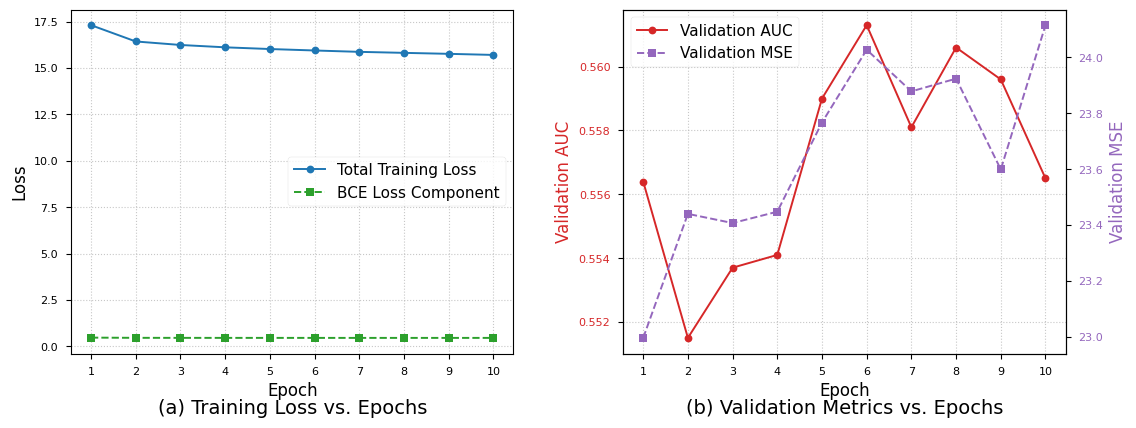

In [ ]:
""" EVALUATION """
import matplotlib.pyplot as plt
import numpy as np

# data from training log
epochs = np.arange(1, 11)

# Training metrics
train_loss = [17.3099, 16.4314, 16.2425, 16.1161, 16.0240, 15.9453, 15.8720, 15.8177, 15.7649, 15.7064]
bce_loss = [0.4686, 0.4574, 0.4557, 0.4548, 0.4545, 0.4543, 0.4539, 0.4539, 0.4539, 0.4540]

# Validation metrics
val_auc = [0.5564, 0.5515, 0.5537, 0.5541, 0.5590, 0.5613, 0.5581, 0.5606, 0.5596, 0.5565]
val_mse = [22.99599, 23.43991, 23.40697, 23.44763, 23.76673, 24.02727, 23.87815, 23.92380, 23.59899, 24.11514]

# create 2-panel figure
plt.style.use('seaborn-v0_8-paper')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Panel (a): Training Loss
ax1.plot(epochs, train_loss, 'o-', label='Total Training Loss', color='tab:blue')
ax1.plot(epochs, bce_loss, 's--', label='BCE Loss Component', color='tab:green')
ax1.set_title('(a) Training Loss vs. Epochs', fontsize=14, y=-0.2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.set_xticks(epochs) # Ensure ticks for every epoch

# Panel (b): Validation Metrics
# Plot AUC on the left y-axis
color1 = 'tab:red'
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation AUC', color=color1, fontsize=12)
ax2.plot(epochs, val_auc, 'o-', label='Validation AUC', color=color1)
ax2.tick_params(axis='y', labelcolor=color1)
ax2.grid(True, linestyle=':', alpha=0.7)

# Create a second y-axis (right) for MSE
ax2_twin = ax2.twinx()
color2 = 'tab:purple'
ax2_twin.set_ylabel('Validation MSE', color=color2, fontsize=12)
ax2_twin.plot(epochs, val_mse, 's--', label='Validation MSE', color=color2)
ax2_twin.tick_params(axis='y', labelcolor=color2)

ax2.set_title('(b) Validation Metrics vs. Epochs', fontsize=14, y=-0.2)
ax2.set_xticks(epochs)

# Add a combined legend for the right plot
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2_twin.legend(lines + lines2, labels + labels2, loc='best', fontsize=11)

# Finalize and Save the Figure
fig.tight_layout(pad=3.0) # Add padding for the titles

plt.savefig('model_training_history.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()